In [1]:
#pip install wordcloud

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json
import requests

import nltk
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

np.random.seed(7)

In [3]:
df_politifact = pd.read_csv('data/politifact_phase2_raw_2018_7_3.csv', error_bad_lines=False)
df_snopes = pd.read_csv('data/snopes_phase2_raw_2018_7_3.csv', error_bad_lines=False)

b'Skipping line 23797: expected 16 fields, saw 18\n'


In [4]:
df_politifact

,politifact_url_phase1,fact_tag_phase1,article_title_phase1,article_claim_phase1,article_claim_citation_phase1,article_published_date_phase1,article_researched_by_phase1,article_edited_by_phase1,article_categories_phase1,original_url_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2
0,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",http://www.foxnews.com/politics/interactive/20...,False,Resource moved,--,NaN,NaN,NaN
1,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",http://www.foxnews.com/politics/2018/06/08/tru...,False,No Error,The bleak presidential portrait painted by the...,A Trump jump in the polls despite the media's ...,2018-06-08,Howard Kurtz
2,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",http://www.rasmussenreports.com/public_content...,False,Resource moved,--,NaN,NaN,NaN
3,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",https://dyn.realclearpolitics.com/epolls/other...,False,Website down,--,NaN,NaN,NaN
4,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",https://www.nbcnews.com/politics/first-read/po...,False,No Error,Breaking News Emails Get breaking news alerts ...,NBC News/WSJ poll: Economic satisfaction under...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50627,http://www.politifact.com/truth-o-meter/statem...,True,An accurate summary of economic stats,"""Corporate profits are up, CEO pay is up, but ...","— Hillary Clinton on Sunday, July 22nd, 2007 i...","Wednesday, August 1st, 2007 at 12:00 a.m.",Caryn Baird,Scott Montgomery,Economy,http://www.forbes.com/2007/05/03/highest-paid-...,False,404 Client Error: Not Found for url: https://w...,--,NaN,NaN,NaN
50628,http://www.politifact.com/truth-o-meter/statem...,True,A fair account of Romney's position,"""I'm for a three-state political solution in I...","— Sam Brownback on Friday, June 8th, 2007 in","Tuesday, July 10th, 2007 at 12:00 a.m.",Nell Benton,Bill Adair,Iraq,http://www.foreignaffairs.org/20070701faessay8...,True,502 Server Error: BAD_GATEWAY for url: https:/...,--,NaN,NaN,NaN
50629,http://www.politifact.com/truth-o-meter/statem...,False,Most scientists say humans cause warming,"""For every single scientist that tells you (gl...","— Tom Tancredo on Tuesday, May 15th, 2007 in C...","Tuesday, June 12th, 2007 at 12:00 a.m.",Bill Adair,Scott Montgomery,"Climate Change, Environment",http://www.ipcc.ch/,True,No Error,"At the 43rd Session of the IPCC in April 2016,...",Intergovernmental Panel on Climate Change,NaN,NaN
50630,http://www.politifact.com/truth-o-meter/statem...,Mostly True,"Correct, but stats came from fri

In [5]:
df_politifact['fact_tag_phase1'].value_counts()

Half-True         10148
False              9478
Mostly False       9169
Mostly True        9139
True               6279
Pants on Fire!     5609
Full Flop           488
Half Flip           218
No Flip             104
Name: fact_tag_phase1, dtype: int64

In [6]:
drop_list = ['Full Flop', 'Half Flip', 'No Flip', 'Half-True']

for k in drop_list:
    df_politifact = df_politifact[df_politifact['fact_tag_phase1'] != k]
df_politifact

,politifact_url_phase1,fact_tag_phase1,article_title_phase1,article_claim_phase1,article_claim_citation_phase1,article_published_date_phase1,article_researched_by_phase1,article_edited_by_phase1,article_categories_phase1,original_url_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2
0,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",http://www.foxnews.com/politics/interactive/20...,False,Resource moved,--,NaN,NaN,NaN
1,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",http://www.foxnews.com/politics/2018/06/08/tru...,False,No Error,The bleak presidential portrait painted by the...,A Trump jump in the polls despite the media's ...,2018-06-08,Howard Kurtz
2,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",http://www.rasmussenreports.com/public_content...,False,Resource moved,--,NaN,NaN,NaN
3,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",https://dyn.realclearpolitics.com/epolls/other...,False,Website down,--,NaN,NaN,NaN
4,http://www.politifact.com/punditfact/statement...,Mostly True,Story says poll shows Trump tied to Obama at s...,"""Trump approval rating better than Obama and R...","— The Gateway Pundit on Saturday, June 9th, 20...","Monday, June 18th, 2018 at 9:00 a.m.",Amy Sherman,Katie Sanders,"Fake news, Polls and Public Opinion",https://www.nbcnews.com/politics/first-read/po...,False,No Error,Breaking News Emails Get breaking news alerts ...,NBC News/WSJ poll: Economic satisfaction under...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50627,http://www.politifact.com/truth-o-meter/statem...,True,An accurate summary of economic stats,"""Corporate profits are up, CEO pay is up, but ...","— Hillary Clinton on Sunday, July 22nd, 2007 i...","Wednesday, August 1st, 2007 at 12:00 a.m.",Caryn Baird,Scott Montgomery,Economy,http://www.forbes.com/2007/05/03/highest-paid-...,False,404 Client Error: Not Found for url: https://w...,--,NaN,NaN,NaN
50628,http://www.politifact.com/truth-o-meter/statem...,True,A fair account of Romney's position,"""I'm for a three-state political solution in I...","— Sam Brownback on Friday, June 8th, 2007 in","Tuesday, July 10th, 2007 at 12:00 a.m.",Nell Benton,Bill Adair,Iraq,http://www.foreignaffairs.org/20070701faessay8...,True,502 Server Error: BAD_GATEWAY for url: https:/...,--,NaN,NaN,NaN
50629,http://www.politifact.com/truth-o-meter/statem...,False,Most scientists say humans cause warming,"""For every single scientist that tells you (gl...","— Tom Tancredo on Tuesday, May 15th, 2007 in C...","Tuesday, June 12th, 2007 at 12:00 a.m.",Bill Adair,Scott Montgomery,"Climate Change, Environment",http://www.ipcc.ch/,True,No Error,"At the 43rd Session of the IPCC in April 2016,...",Intergovernmental Panel on Climate Change,NaN,NaN
50630,http://www.politifact.com/truth-o-meter/statem...,Mostly True,"Correct, but stats came from fri

In [7]:
df_politifact['fact_tag_phase1'].value_counts()

False             9478
Mostly False      9169
Mostly True       9139
True              6279
Pants on Fire!    5609
Name: fact_tag_phase1, dtype: int64

In [8]:
df_politifact['article_title_phase1'][0]

'Story says poll shows Trump tied to Obama at same point in presidency'

In [9]:
df_snopes

,fact_rating_phase1,snopes_url_phase1,article_title_phase1,article_category_phase1,article_date_phase1,article_claim_phase1,article_origin_url_phase1,index_paragraph_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2
0,true,https://www.snopes.com/fact-check/lori-mcallen...,Did an Oregon Department of Transportation Emp...,Viral Phenomena Viral Phenomena,21 June 2018,"In June 2018, Oregon DOT employee Lori McAllen...",http://archive.is/HpML7,2,False,No Error,Reddit Voat Twitter VKontakte Pinboard Livejou...,She works for ODOT/DMV...Let's make her famous.,2018-06-21,NaN
1,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.dallasnews.com/news/immigration/20...,1,True,No Error,"A Southwest Key spokeswoman, Cindy Casares, ha...",Texas nonprofit has received $1.5 billion in f...,2018-06-19,Jennifer Emily
2,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.bloomberg.com/news/articles/2018-0...,1,False,No Error,The Trump administration plans to pay a Texas ...,Trump’s Immigrant Child Detentions Mean $458 M...,2018-06-19,Alex Wayne
3,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.bloomberg.com/news/articles/2018-0...,6,False,No Error,The Trump administration plans to pay a Texas ...,Trump’s Immigrant Child Detentions Mean $458 M...,2018-06-19,Alex Wayne
4,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://web.archive.org/web/20180604042055/htt...,10,False,No Error,Who We Are Southwest Key Programs is a private...,Who We Are: Southwest Key Programs,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,legend,https://www.snopes.com/fact-check/faces-in-the...,Faces in the Cloud,September 11th,21 September 2001,Images of the World Trade Center fire reveal t...,http://www.markdphillips.com,1,True,No Error,The best skiers in the world came to the East ...,Photography of the real world,NaN,NaN
20771,legend,https://www.snopes.com/fact-check/faces-in-the...,Faces in the Cloud,September 11th,21 September 2001,Images of the World Trade Center fire reveal t...,http://www.skepdic.com/pareidol.html,7,False,No Error,pareidolia There is an universal tendency amon...,the Skeptic's Dictionary,NaN,NaN
20772,legend,https://www.snopes.com/fact-check/ice-badges/,ICE Badges,Inboxer Rebellion Immigration,24 May 2006,E-mail describes ruse intended to scare away l...,http://www.ice.gov/,2,False,No Error,If your school’s SEVP certification has been w...,ICE,NaN,NaN
20773,legend,https://www.snopes.com/fact-check/c3p0-trading...,Risqué ‘Star Wars’ C-3P0 Trading Card,Entertainment Risqué Business,16 August 2007,A Star Wars trading card was altered to depict...,http://www.starwars.com/,3,False,No Error,Imperial medics tend to soldiers on the battle...,The Official Star Wars Website,NaN,Check Out New Books


In [10]:
df_snopes['fact_rating_phase1'].value_counts()

false                  11247
mixture                 2595
mostly false            2020
true                    1903
unproven                1737
mostly true              664
miscaptioned             302
outdated                 106
misattributed             58
scam                      53
legend                    49
correct attribution       41
Name: fact_rating_phase1, dtype: int64

### Final Data Sources

In [11]:
df_KaggleTrain = pd.read_csv('data/KaggleTrain.csv')

In [12]:
#1: unreliable
#0: reliable
df_KaggleTrain

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [13]:
df_KaggleTrain.drop(['author', 'id'], axis=1, inplace=True)
df_KaggleTrain

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


In [14]:
df_DataFlair = pd.read_csv('data/DataFlairnews.csv')

In [15]:
df_DataFlair

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [16]:
df_DataFlair['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [17]:
df_DataFlair.text[0]

'Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. \nThe word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. \nBut that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. \nThe FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. \nThe FBI’s leadership is being warned that the entir

In [18]:
df_DataFlair.drop('Unnamed: 0', axis=1, inplace=True)
df_DataFlair

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [19]:
df_ISOT_true = pd.read_csv('data/ISOTTrue.csv')
df_ISOT_false = pd.read_csv('data/ISOTFake.csv')

In [20]:
df_ISOT_false

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [21]:
df_ISOT_true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [22]:
df_ISOT_true['label'] = 0
df_ISOT_false['label'] = 1
df_ISOT_true.drop(['subject', 'date'], axis=1, inplace=True)
df_ISOT_false.drop(['subject', 'date'], axis=1, inplace=True)

### Data Description

ISOT - focused mostly on collecting articles from 2016 to 2017. https://www.uvic.ca/engineering/ece/isot/datasets/fake-news/index.php <br>
Kaggle - https://www.kaggle.com/c/fake-news/overview <br>
Dataflair - https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

In [23]:
dfList = [df_ISOT_true, df_ISOT_false, df_DataFlair, df_KaggleTrain]
df_MAIN = pd.concat(dfList, ignore_index=True)
df_MAIN

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
72030,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
72031,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


In [24]:
df_MAIN['label'].value_counts()

1       33894
0       31804
REAL     3171
FAKE     3164
Name: label, dtype: int64

In [25]:
#0 = True
#1 = False

conditions = [
    df_MAIN['label'] == 1, 
    df_MAIN['label'] == 0,
    df_MAIN['label'] == 'REAL',
    df_MAIN['label'] == 'FAKE'
]

choices = [
    1, 
    0, 
    0,
    1
]

df_MAIN['label'] = np.select(conditions, choices, default='NA')
df_MAIN['label'].value_counts()

1    37058
0    34975
Name: label, dtype: int64

In [26]:
df = df_MAIN
df

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
72030,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
72031,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72033 entries, 0 to 72032
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71475 non-null  object
 1   text    71994 non-null  object
 2   label   72033 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [28]:
df.dropna(axis=0, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71436 entries, 0 to 72032
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71436 non-null  object
 1   text    71436 non-null  object
 2   label   71436 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [34]:
#removing Reuters heading

def reuters(text):
    reuters = '(Reuters) - '
    if reuters in text:
        return text[text.find(reuters)+len(reuters):]
    else:
        return text

df['text_cleaned'] = df['text'].apply(reuters)
df

,title,text,label,text_cleaned,text_tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,The head of a conservative Republican faction ...,"[washington, reuters, head, conservative, repu..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,Transgender people will be allowed for the fir...,"[washington, reuters, transgender, people, all..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,The special counsel investigation of links bet...,"[washington, reuters, special, counsel, invest..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,Trump campaign adviser George Papadopoulos tol...,"[washington, reuters, trump, campaign, adviser..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,President Donald Trump called on the U.S. Post...,"[seattlewashington, reuters, president, donald..."
...,...,...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,Rapper T. I. unloaded on black celebrities who...,"[rapper, unloaded, black, celebrities, met, do..."
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,When the Green Bay Packers lost to the Washing...,"[green, bay, packers, lost, washington, redski..."
72030,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0,The Macy’s of today grew from the union of sev...,"[macy, ’, today, grew, union, several, great, ..."
72031,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal...","[nato, russia, hold, parallel, exercises, balk..."


In [35]:
punct = set(string.punctuation)
words = set(stopwords.words("english"))

def tokenize_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in punct]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return nltk.word_tokenize(text_no_doublespace)

df['text_tokenized'] = df['text_cleaned'].apply(tokenize_text)
df

,title,text,label,text_cleaned,text_tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,The head of a conservative Republican faction ...,"[the, head, of, a, conservative, republican, f..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,Transgender people will be allowed for the fir...,"[transgender, people, will, be, allowed, for, ..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,The special counsel investigation of links bet...,"[the, special, counsel, investigation, of, lin..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,Trump campaign adviser George Papadopoulos tol...,"[trump, campaign, adviser, george, papadopoulo..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,President Donald Trump called on the U.S. Post...,"[president, donald, trump, called, on, the, us..."
...,...,...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,Rapper T. I. unloaded on black celebrities who...,"[rapper, t, i, unloaded, on, black, celebritie..."
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,When the Green Bay Packers lost to the Washing...,"[when, the, green, bay, packers, lost, to, the..."
72030,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0,The Macy’s of today grew from the union of sev...,"[the, macy, ’, s, of, today, grew, from, the, ..."
72031,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal...","[nato, russia, to, hold, parallel, exercises, ..."


In [36]:
#removing stopwords
df['text_tokenized'] = df['text_tokenized'].apply(lambda x: [item for item in x if item not in words])
df

,title,text,label,text_cleaned,text_tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,The head of a conservative Republican faction ...,"[head, conservative, republican, faction, us, ..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,Transgender people will be allowed for the fir...,"[transgender, people, allowed, first, time, en..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,The special counsel investigation of links bet...,"[special, counsel, investigation, links, russi..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,Trump campaign adviser George Papadopoulos tol...,"[trump, campaign, adviser, george, papadopoulo..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,President Donald Trump called on the U.S. Post...,"[president, donald, trump, called, us, postal,..."
...,...,...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,Rapper T. I. unloaded on black celebrities who...,"[rapper, unloaded, black, celebrities, met, do..."
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,When the Green Bay Packers lost to the Washing...,"[green, bay, packers, lost, washington, redski..."
72030,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0,The Macy’s of today grew from the union of sev...,"[macy, ’, today, grew, union, several, great, ..."
72031,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal...","[nato, russia, hold, parallel, exercises, balk..."


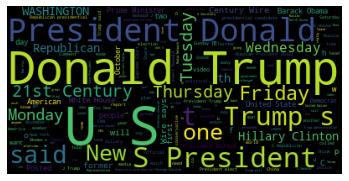

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
text = WordCloud().generate(df['text_cleaned'].to_string())
plt.imshow(text)
plt.axis("off")
plt.show()